In [1]:
import pandas as pd
import numpy as np

import datetime as dt

import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)
from math import ceil

In [2]:
import statsmodels.stats.api as sms
import scipy.stats as st

#importing packages
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [5]:
path =r'C:\Users\vsekar\Desktop\Kaiser AI Garage AAI_S&A_A&C\Tasks\Dataset\AB_Test\ab_data.csv'

In [7]:
data =pd.read_csv(path)

In [8]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['NameofDay'] = ((pd.DatetimeIndex(data.timestamp).day_name()))

In [9]:
data['WEEKDAY'] = ((pd.DatetimeIndex(data.timestamp).dayofweek) // 5 == 1).astype(int)

In [10]:
data.head()

,user_id,timestamp,group,landing_page,converted,NameofDay,WEEKDAY
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,Saturday,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,Thursday,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,Wednesday,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,Sunday,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,Saturday,1


In [11]:
data.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
NameofDay               object
WEEKDAY                  int32
dtype: object

In [12]:
data.timestamp.max() , data.timestamp.min()

(Timestamp('2017-01-24 13:41:54.460509'),
 Timestamp('2017-01-02 13:42:05.378582'))

In [13]:
List =['Wednesday','Saturday']

In [14]:
df_filtered = data[data['NameofDay'].isin(List)]

In [15]:
df_filtered.head()

,user_id,timestamp,group,landing_page,converted,NameofDay,WEEKDAY
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,Saturday,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,Wednesday,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,Saturday,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,Wednesday,0
10,929503,2017-01-18 05:37:11.527370,treatment,new_page,0,Wednesday,0


In [16]:
df =df_filtered.copy()

In [17]:
df.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted',
       'NameofDay', 'WEEKDAY'],
      dtype='object')

In [18]:
df = df[['user_id', 'group', 'WEEKDAY','converted']]

In [19]:
df.head()

,user_id,group,WEEKDAY,converted
0,851104,control,1,0
2,661590,treatment,0,0
4,864975,control,1,1
8,817355,treatment,0,1
10,929503,treatment,0,0


In [20]:
df.shape

(80307, 4)

In [21]:
# Where treatment does not match with new_page or control does not match with old_page
i = df[((df['group']=='treatment') ==(df['WEEKDAY']==1)) == False].index

In [22]:
len(i)

40238

In [23]:
# Drop those rows
df2 = df.drop(i)

In [24]:
df2[((df2['group'] == 'treatment') == (df2['WEEKDAY'] == 1)) == False].shape

(0, 4)

In [25]:
df2.shape

(40069, 4)

In [26]:
j = df2[((df2['group']=='control') ==(df2['WEEKDAY']==0)) == False].index

In [27]:
len(j)

0

In [28]:
#The number of unique users in the dataset.
df2['user_id'].nunique()

39986

In [29]:
# Number of duplicate rows
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,group,WEEKDAY,converted
4602,656983,control,0,0
6047,799530,control,0,0
7421,901750,control,0,0
8284,728122,control,0,0
9501,734626,treatment,1,0
...,...,...,...,...
286944,643869,treatment,1,1
288080,792832,treatment,1,0
288403,764120,control,0,0
290074,760743,treatment,1,0


In [30]:
# Drop the row and keep the first row
df2.drop_duplicates(subset ='user_id',keep ='first',inplace = True)

In [31]:
# The proportion of users converted.
df2.converted.mean()

0.11936677837243036

In [32]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39986 entries, 11 to 294470
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    39986 non-null  int64 
 1   group      39986 non-null  object
 2   WEEKDAY    39986 non-null  int32 
 3   converted  39986 non-null  int64 
dtypes: int32(1), int64(2), object(1)
memory usage: 1.4+ MB


In [33]:
#Missing values
df2.isnull().any()

user_id      False
group        False
WEEKDAY      False
converted    False
dtype: bool

In [34]:
# Prob of conversion regardless of the group
(df2.query('converted == 1').converted.count())/df2.shape[0]

0.11936677837243036

In [35]:
# Prob of conversion regardless of the group
(df2.query('converted == 0').converted.count())/df2.shape[0]

0.8806332216275696

In [36]:
# Prob of conversion in control group
control_df = df2.query('group =="control"')
Pold = control_df['converted'].mean()
Pold

0.12164597517020424

In [37]:
control_df.WEEKDAY.unique()

array([0])

In [38]:
# Prob of conversion in treatment group
treatment_df = df2.query('group =="treatment"')
Pnew = treatment_df['converted'].mean()
Pnew

0.11709145427286356

In [39]:
treatment_df.WEEKDAY.unique()

array([1])

In [40]:
#Check how many duplicated users exist
print(df2["user_id"].count())
print(df2["user_id"].nunique())

39986
39986


In [41]:
# proportion of users converted
converted = round(df2.query('converted == 1').user_id.nunique() / df2.user_id.nunique()*100, 2 )
print('The number of users converted across two groups {} %'.format(converted))

The number of users converted across two groups 11.94 %


In [42]:
# proportion of users not converted
Not_converted = round(df2.query('converted == 0').user_id.nunique() / df2.user_id.nunique()*100,2)
print('The number of users Not converted across two groups {} %'.format(Not_converted))

The number of users Not converted across two groups 88.06 %


In [43]:
df2.groupby('group')[['user_id','converted']].agg({'user_id' : 'count', 'converted':['sum']}).reset_index().rename(columns={'sum':'Total_Conversions','count':'Total_Users'})

,group,user_id,converted
,,Total_Users,Total_Conversions
0,control,19976,2430
1,treatment,20010,2343


In [44]:
#Show the % split between users who saw new vs old page
#Calculate pooled probability
mask = (df2["group"] == 'control')
conversions_control = df2["converted"][mask].sum()
total_users_control = df2["converted"][mask].count()

mask100 = (df2["group"] == 'treatment')
conversions_treatment = df2["converted"][mask100].sum()
total_users_treatment = df2["converted"][mask100].count()

In [45]:
#control
conversions_control, total_users_control

(2430, 19976)

In [46]:
#treatment
conversions_treatment,total_users_treatment

(2343, 20010)

In [47]:
print("Split of control users who got call in weedend vs Experiment group  users who got call in weekdays: ", 
          round(total_users_control / df2["converted"].count() * 100, 2), "% ",
          round((total_users_treatment / df2["converted"].count()) * 100, 2), "%")

Split of control users who got call in weedend vs Experiment group  users who got call in weekdays:  49.96 %  50.04 %


In [48]:
#count number of users who converted in each group
print("Number of control users who converted on old page: ", conversions_control)
print("Percentage of control users who converted: ", round((conversions_control / total_users_control) * 100, 2), "%")


print("Number of treatment users who converted on new page: ", conversions_treatment)
print("Percentage of treatment users who converted: ", round((conversions_treatment/ total_users_treatment) * 100, 2), "%")

print('The total number of users in control group',total_users_control)
print('The total number of users in tratement group',total_users_treatment)
print("Difference between the users in both group is",(-total_users_control+total_users_treatment))

Number of control users who converted on old page:  2430
Percentage of control users who converted:  12.16 %
Number of treatment users who converted on new page:  2343
Percentage of treatment users who converted:  11.71 %
The total number of users in control group 19976
The total number of users in tratement group 20010
Difference between the users in both group is 34


In [49]:
#What is the conversion rate for  pnew  under the null?
P_new = treatment_df['converted'].mean()
P_new

0.11709145427286356

In [50]:
#What is the conversion rate for  pold  under the null?
P_old = control_df['converted'].mean()
P_old

0.12164597517020424

In [51]:
# What is  nnew , the number of individuals in the treatment group?
n_new = treatment_df.shape[0]
n_new

20010

In [52]:
# What is  nold , the number of individuals in the control group?
n_old = control_df.shape[0]
n_old

19976

In [53]:
#Simulate  nnew  transactions with a conversion rate of  pnew  under the null. Store these  nnew  1's and 0's in converted.

new_page_converted = np.random.binomial(1,P_new,n_new)
new_page_converted.mean()

0.12048975512243879

In [54]:
#Simulate  nold  transactions with a conversion rate of  pold  under the null. Store these  nold  1's and 0's in converted.
old_page_converted = np.random.binomial(1,P_old,n_old)
old_page_converted.mean()

0.1265018021625951

In [55]:
# Find  pnew  -  pold  for your simulated values from part (e) and (f).
d = new_page_converted.mean() - old_page_converted.mean()
d

-0.006012047040156315

In [56]:
p_diffs =[]
size = df2.shape[0]
for _ in range(1000):
    new_page_converted = np.random.binomial(1,P_new, n_new)
    old_page_converted = np.random.binomial(1,P_old, n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

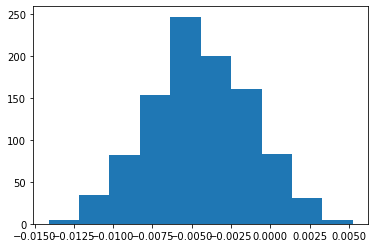

In [57]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

In [58]:
df2

,user_id,group,WEEKDAY,converted
11,834487,treatment,1,0
33,931013,treatment,1,0
34,710349,control,0,0
36,831737,control,0,1
45,702260,control,0,0
...,...,...,...,...
294435,886374,treatment,1,0
294445,653124,treatment,1,0
294465,925675,treatment,1,0
294469,755438,control,0,0


In [59]:
act_new_conversion = df2.query('converted == 1 and WEEKDAY == 0')['user_id'].nunique()/n_new

In [60]:
act_old_conversion  = df2.query('converted == 1 and WEEKDAY ==1')['user_id'].nunique()/n_old

In [61]:
obs_diff = act_new_conversion - act_old_conversion
obs_diff

0.004148531461141677

In [62]:
#P-value
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

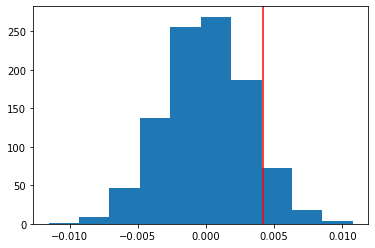

In [63]:
plt.hist(null_vals)
plt.axvline(x=obs_diff,color ='red')

In [64]:
(null_vals > obs_diff).mean()

0.091

In [65]:
effect_size = sms.proportion_effectsize(0.1, 0.2)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8,  # probability of a type I error, that is wrong rejections if the Null Hypothesis is true
    alpha=0.05, #is one minus the probability of a type II error
    ratio=1 #ratio of the number of observations in sample 2 relative to sample 1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)

In [ ]:
#https://towardsdatascience.com/required-sample-size-for-a-b-testing-6f6608dd330a#:~:text=Sample%20Size%20for%20Comparing%20Two,actually%20the%20number%20of%20days.

In [72]:
effect_size

-0.2837941092083278

In [66]:
required_n

195

In [67]:
ab_group = df2.copy()

control_sample = ab_group[ab_group['group'] == 'control'].sample(n=required_n, random_state=22) 
treatment_sample = ab_group[ab_group['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
print(ab_test.shape)

conversion_rates = ab_test.groupby('group')['converted']
std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: sms.stattools.stats.sem(x, ddof=0)           # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
print('The conversion rate with mean value{} and std{} and stderror {}'.format(conversion_rates.mean(),std_p,se_p))

(390, 4)
The conversion rate with mean valuemean          0.110256
<lambda_0>    0.311016
<lambda_1>    0.022272
dtype: float64 and std<function <lambda> at 0x000002A05174CDC0> and stderror <function <lambda> at 0x000002A05174CD30>


In [68]:
df2.shape,ab_test.shape

((39986, 4), (390, 4))

In [69]:
control_results = ab_test[ab_test['WEEKDAY'] == 1]['converted']
treatment_results = ab_test[ab_test['WEEKDAY'] == 0]['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

In [70]:
z_stat, pval = proportions_ztest(successes, nobs=nobs,alternative='smaller')
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.46
p-value: 0.927
ci 95% for control group: [0.086, 0.181]
ci 95% for treatment group: [0.048, 0.127]


In [71]:
if pval<0.05:
    print('The experiment has made an imp.Experiment performed better than control. It is statistically and practically significant')
else:
    print('It is not significant.Control is better than the Experiment. Hence, No need to make changes')  

It is not significant.Control is better than the Experiment. Hence, No need to make changes
